In [1]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

In [2]:
# Load an image
img = cv2.imread('../assets/images/example.jpg')[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'sharpen': True,  # Use the DF normalization (should be True)
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'optimize': False,  # Whether to refine the lines after detecting them
        'use_vps': True,  # Whether to use vanishing points (VPs) in the refinement
        'optimize_vps': True,  # Whether to also refine the VPs in the refinement
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

/home/remi/env_deeplsd/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


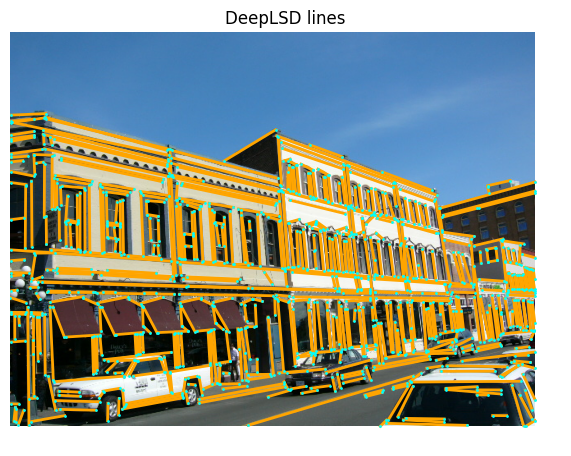

In [3]:
# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))